# Import

In [1]:
import numpy as np
from scipy.stats import norm
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import statistics
from scipy import signal
from scipy.optimize import curve_fit
import scipy.fftpack
from mpl_toolkits.mplot3d import Axes3D
from cycler import cycler
from scipy import interpolate

In [2]:
#%matplotlib notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Reading files

In [3]:
common_folder = "/home/gorbunov8a/Documents/MATLAB/data/corr/"

Rl = 60; N=128
folder_in = "big_ts/real_kstar/run1/"
folder_in = "dt02/run1/"
nb_of_windows = 2794 + 1

# folder_in = "dt002/run1/"
# nb_of_windows = 276+1

spec_component = "xx"
correlation_type = "two_point_corr"
spec_type = "lin"

# read average correlation files
for iw in list(range(nb_of_windows)) :
    folder = common_folder + "rl" + str(Rl) + "_N" + str(N) + "/" + folder_in
    if (iw < 1000) :
        file = folder + correlation_type + "_" + spec_type + "_C" + spec_component + "_wi=" + "%03d" % iw + ".table"
    else : 
        file = folder + correlation_type + "_" + spec_type + "_C" + spec_component + "_wi=" + "%06d" % iw + ".table"
    file_data = []
    for line in open(file) :
        temp_array_line = []
        if line[0] == '#' :          #skip commented lines
            continue
        else :
            try :
                temp_array_line=list(map(float, line.split( )))
                file_data.append(temp_array_line)  
            except : 
                temp_array_line = []
                print('Not a number in the input')
                continue
    k = np.array(file_data[0])
    nb_of_modes = np.array(file_data[1])
    table = np.array(file_data[2:])
    t = table[:,0]
    if (iw == 0) :
        correlation_mean = np.empty([t.shape[0], k.shape[0], nb_of_windows])
    correlation_mean[:,:, iw] = table[:,1:]
    
correlation_type = "two_point_corr_variance"
# read variation of correlation files
for iw in list(range(nb_of_windows)) :
    folder = common_folder + "rl" + str(Rl) + "_N" + str(N) + "/" + folder_in
    if (iw < 1000) :
        file = folder + correlation_type + "_" + spec_type + "_C" + spec_component + "_wi=" + "%03d" % iw + ".table"
    else : 
        file = folder + correlation_type + "_" + spec_type + "_C" + spec_component + "_wi=" + "%06d" % iw + ".table"
    file_data = []
    for line in open(file) :
        temp_array_line = []
        if line[0] == '#' :          #skip commented lines
            continue
        else :
            try :
                temp_array_line=list(map(float, line.split( )))
                file_data.append(temp_array_line)  
            except : 
                print('Not a number in the input')
                continue
    k = np.array(file_data[0])
    nb_of_modes = np.array(file_data[1])
    table = np.array(file_data[2:])
    t = table[:,0]
    if (iw == 0) :
        correlation_var = np.empty([t.shape[0], k.shape[0], nb_of_windows])
    correlation_var[:,:,iw] = table[:,1:]

del file_data, table

In [4]:
correlation_mean.shape

(251, 64, 2795)

In [5]:
correlation_var.shape

(251, 64, 2795)

In [6]:
k

array([ 1.27614244,  2.2308032 ,  3.13415931,  4.06058   ,  5.09758338,
        6.12192851,  7.07174362,  8.02507874,  9.05738988, 10.09335596,
       11.06124973, 12.02913549, 13.04476653, 14.05374178, 15.01660467,
       16.00462119, 17.03177817, 18.05251133, 19.03634387, 20.01856527,
       21.03215692, 22.03599441, 23.02170454, 24.009066  , 25.01482853,
       26.02846656, 27.02856889, 28.0273837 , 29.02981944, 30.02467252,
       31.0205757 , 32.01280743, 33.00798299, 34.0175855 , 35.01933124,
       36.01563287, 37.01917885, 38.0203591 , 39.01233417, 40.00734728,
       41.01532305, 42.02013021, 43.01793081, 44.01610593, 45.02010908,
       46.0194069 , 47.00675301, 48.00230033, 49.00986221, 50.01855107,
       51.01649512, 52.01383929, 53.01826507, 54.01789345, 55.01014403,
       56.00353273, 57.00977504, 58.01381661, 59.00889601, 60.00998342,
       61.01341449, 62.01490137, 63.0057401 , 63.7470648 ])

# Define parameters

In [7]:
# PARAMETERS
pi = np.pi
if (Rl == 90) :
    lmbda = 0.268 
    eta = 0.0134  
    L=2.65
    dissipation_rate=0.31e-04
    urms=np.sqrt(3*0.2282712E-02/2)
elif (Rl == 60) :
    lmbda = 0.387 
    eta = 0.025   
    L=2.65  
    dissipation_rate=2.24565e-06
elif (Rl == 240) :
    lmbda = 0.09986 
    eta = 0.003176  
    L = 2.3
t0=dissipation_rate**(-1/3)*L**(2/3) #large scale eddy-turnover time
spatial_scales = np.array([L, lmbda, eta])
normalization_status = True

# Normalization

In [8]:
t_length = t.shape[0]
wavenumbers_length = k.shape[0]
curves = np.arange(nb_of_windows)

wn_scales = 2.0*np.pi/spatial_scales
kL = 2.0*pi/L; klmbda = 2.0*pi/lmbda; keta = 2.0*pi/eta

mean_sqr = correlation_var + correlation_mean**2
snr = correlation_var/mean_sqr

normalization = 1.0/correlation_mean[0, :, :]

# Plotting params

In [9]:
if (spec_type == "lin") :
    kmin = 8
    kmax = 60
    nb_of_curves = 20
elif (spec_type == "kstar") :
    kmin = 2
    kmax = 21
    nb_of_curves = 20
step = round((kmax - kmin)/nb_of_curves)
indices_of_k_to_plot=list(range(kmin,kmax,step))
#indices_of_k_to_plot.append(40)
print(indices_of_k_to_plot)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
plt.rc('axes', prop_cycle=cycler(cycler(linestyle=['-', '--', ':', '-.'])*cycler(color=colors)))
plt.rc('axes', labelsize=20)  
plt.rc('axes', titlesize=20)  
plt.rc('legend', fontsize=16)

[8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47, 50, 53, 56, 59]


# Plot correlation function

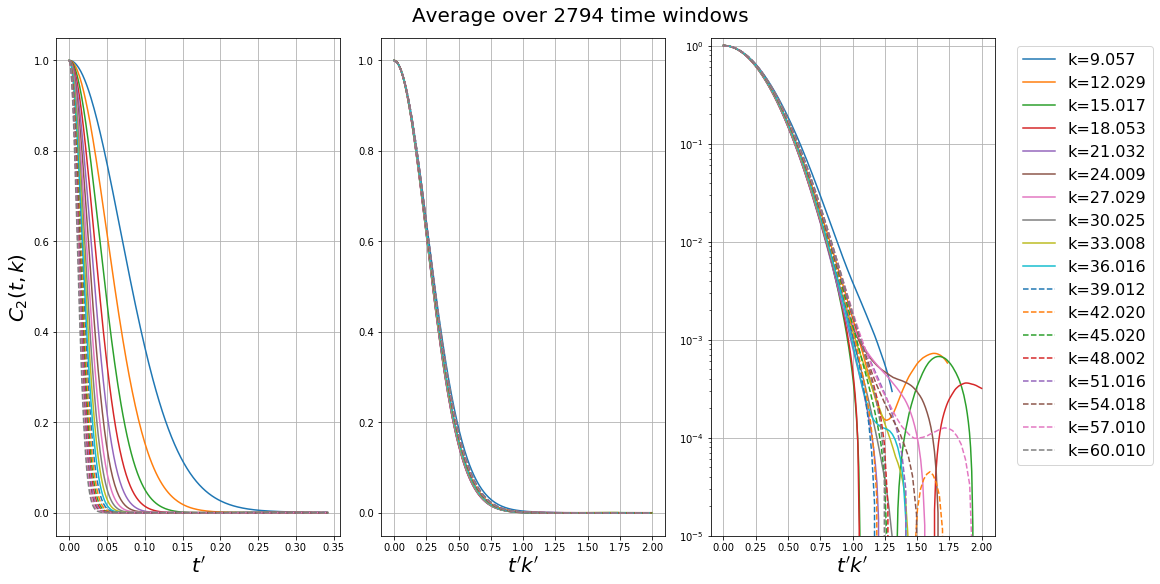

In [10]:
tk1 = 0.0
tk2 = 2.0
iw = -1

vertical_lines = [0.2, 0.7, 1.2, 1.8]

fig, (norm_scale, tk_scale, log_scale) = plt.subplots(nrows=1, ncols=3,figsize=(16,8), constrained_layout=True)
for ik in indices_of_k_to_plot :
    a = np.searchsorted(t/t0*k[ik]/kL, tk1)
    b = np.searchsorted(t/t0*k[ik]/kL, tk2)
    norm_scale.plot(t/t0, correlation_mean[:,ik,iw]*normalization[ik, iw])
    tk_scale.plot(t[a:b]/t0*(k[ik]/kL), correlation_mean[a:b,ik, iw]*normalization[ik, iw])
    log_scale.semilogy(t[a:b]/t0*(k[ik]/kL), correlation_mean[a:b,ik, iw]*normalization[ik, iw], label='k=%2.3f' % (k[ik]))
    #tk2_scale.semilogy(np.sqrt(t[a:b]/t0)*(k[ik]/kL), correlation_mean[a:b,ik, iw]*normalization[ik, iw], label='k=%2.3f' % (k[ik]))
norm_scale.set(ylabel=r'$C_2 (t,k)$', xlabel=r'$t^\prime$'); norm_scale.grid()
tk_scale.set(xlabel=r'$t^\prime k^\prime$'); tk_scale.grid()
log_scale.set(xlabel=r'$t^\prime k^\prime$', ylim=[10e-6, 1.2]); log_scale.grid()
#tk2_scale.set(xlabel=r'$t^\prime k^\prime$', ylim=[10e-6, 1.2]); tk2_scale.grid()
lgd = log_scale.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# for line in vertical_lines : log_scale.axvline(x=line, ls='-', color='dimgray'); tk_scale.axvline(x=line, ls='-', color='dimgray')
# ax2 = tk_scale.twiny(); ax2.set(xlim = tk_scale.get_xlim())
# ax2.set_xticks(vertical_lines); ax2.set_xticklabels(vertical_lines)
# ax2 = log_scale.twiny(); ax2.set(xlim = log_scale.get_xlim())
# ax2.set_xticks(vertical_lines); ax2.set_xticklabels(vertical_lines)

fig.suptitle('Average over %4.0f time windows' % (curves.shape[0] + iw), size=20) 
#plt.show()

# Export image to pdf
pp = PdfPages('Images/Correlation/pcurves.pdf')
pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
pp.close()

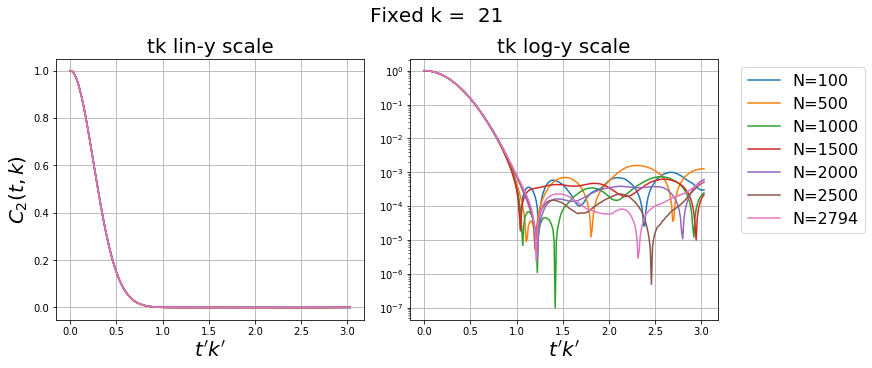

In [66]:
tk1 = 0.0
tk2 = 10.0
iw_set = [100,500,1000,1500,2000,2500,-1]
ik = 20

fig, (ax_lin, ax_log) = plt.subplots(nrows=1, ncols=2,figsize=(12,5), constrained_layout=True)
a = np.searchsorted(t/t0*k[ik]/kL, tk1)
b = np.searchsorted(t/t0*k[ik]/kL, tk2)
ybars = (np.sqrt(np.abs(correlation_var))*normalization)[:,ik,iw]
resample = 10

for iw in iw_set :
    #ax_lin.errorbar(t[a:b]/t0*(k[ik]/kL), correlation_mean[a:b,ik, iw]*normalization[ik, iw], yerr=ybars[a:b], errorevery=resample, label='iw=%2.f' % (iw))
    #ax_log.errorbar(t[a:b]/t0*(k[ik]/kL), correlation_mean[a:b,ik, iw]*normalization[ik, iw], yerr=ybars[a:b], errorevery=resample, label='iw=%2.f' % (iw))
    ax_lin.plot(t[a:b]/t0*(k[ik]/kL), correlation_mean[a:b,ik, iw]*normalization[ik, iw], label='N=%2.f' % (curves[iw]))
    ax_log.plot(t[a:b]/t0*(k[ik]/kL), np.abs(correlation_mean[a:b,ik, iw]*normalization[ik, iw]), label='N=%2.f' % (curves[iw]))
    
ax_lin.set(title='tk lin-y scale', xlabel=r'$t^\prime k^\prime$', ylabel=r'$C_2 (t,k)$'); ax_lin.grid(); #ax_lin.set( xlim=[1.0, 3.0], ylim=[-0.023, 0.0095])
ax_log.set(title='tk log-y scale', xlabel=r'$t^\prime k^\prime$'); ax_log.grid()
ax_log.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax_log.set_yscale("log", nonposy='clip')

fig.suptitle('Fixed k =%4.0f' % (k[ik]), size=20) 
plt.show()

# Average over wavenumbers

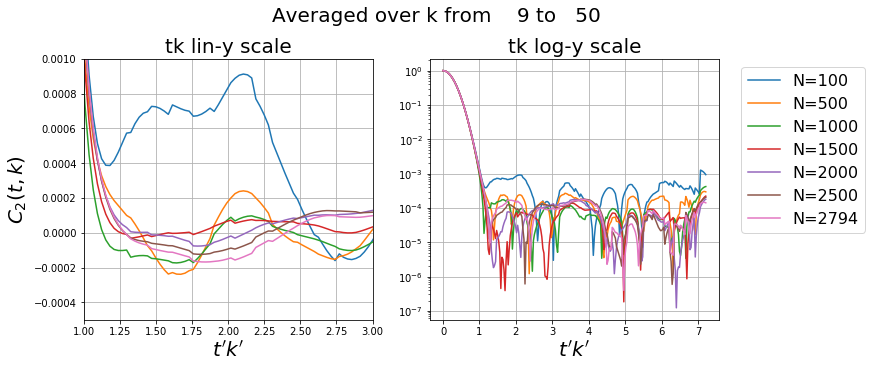

In [67]:
tk1 = 0.0
tk2 = 10.0
iw_set = [100,500,1000,1500,2000,2500,-1]

fig, (ax_lin, ax_log) = plt.subplots(nrows=1, ncols=2,figsize=(12,5), constrained_layout=True)
a = np.searchsorted(t/t0*k[ik]/kL, tk1)
b = np.searchsorted(t/t0*k[ik]/kL, tk2)

ikrange = np.arange(8,50)
xnew = t/t0*k[ikrange[-1]]/kL

for iw in iw_set :
    avg_c2 = np.zeros(shape=t_length, dtype=float)
    avg_counter = np.zeros(shape=t_length, dtype=float)
    for ik in ikrange : 
        f = interpolate.interp1d(t/t0*k[ik]/kL, correlation_mean[::,ik, iw]*normalization[ik,iw], bounds_error=False)
        ynew = f(xnew)
        for it in list(range(t.shape[0])) :
            if (~np.isnan(ynew[it])) :
                avg_c2[it] = avg_c2[it] + ynew[it]
                avg_counter[it] = avg_counter[it] + 1
            else :
                continue
    avg_c2 = avg_c2/avg_counter
    
    ax_lin.plot(xnew, avg_c2, label='N=%2.f' % (curves[iw]))
    ax_log.plot(xnew, np.abs(avg_c2), label='N=%2.f' % (curves[iw]))
    
ax_lin.set(title='tk lin-y scale', xlabel=r'$t^\prime k^\prime$', ylabel=r'$C_2 (t,k)$'); ax_lin.grid(); 
ax_lin.set( xlim=[1.0, 3.0], ylim=[-0.0005, 0.001])
ax_log.set(title='tk log-y scale', xlabel=r'$t^\prime k^\prime$'); ax_log.grid()
ax_log.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax_log.set_yscale("log", nonposy='clip')

fig.suptitle('Averaged over k from %4.0f to %4.0f' %(k[ikrange[0]], k[ikrange[-1]]), size=20) 
plt.show()

In [47]:
# fig = plt.figure()
# ax = fig.gca(projection='3d')
# ik = 10
# Z = (correlation_mean*normalization)[:,11,:]
# X, Y = np.meshgrid(curves, t)
# ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
# plt.show()

# Evolution of mean and std

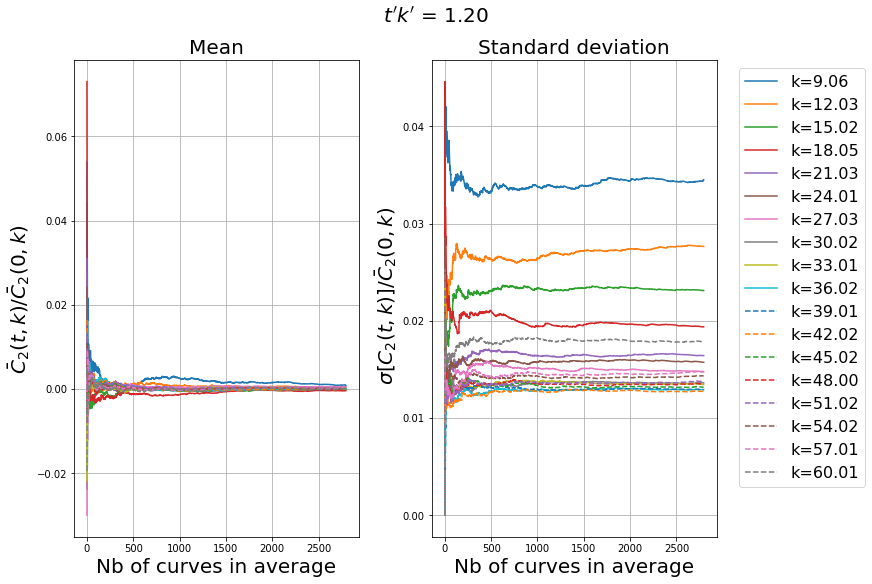

In [48]:
tk = 1.2

fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(12,8))
x1 = 0
for ik in indices_of_k_to_plot :
    it = np.searchsorted(t/t0*k[ik]/kL, tk)
    if (it < t.shape[0]) : 
        axs[0].plot(curves[x1:], (correlation_mean*normalization)[it,ik,x1:])
        axs[1].plot(curves[x1:], (np.sqrt(np.abs(correlation_var))*normalization)[it,ik,x1:],label='k=%2.2f' % (k[ik]))
axs[0].set(yscale='linear', xlabel='Nb of curves in average', ylabel=r'$\bar{C}_2 (t,k)  / \bar{C}_2(0,k) $', title='Mean'); axs[0].grid()
axs[1].set(yscale='linear', xlabel='Nb of curves in average', ylabel=r' $ \sigma [C_2(t, k)] / \bar{C}_2(0,k)$', title='Standard deviation'); axs[1].grid()
axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

fig.suptitle(r'$t^\prime k^\prime$ = %2.2f' % tk, size=20)
plt.show()

# RMS of the tail

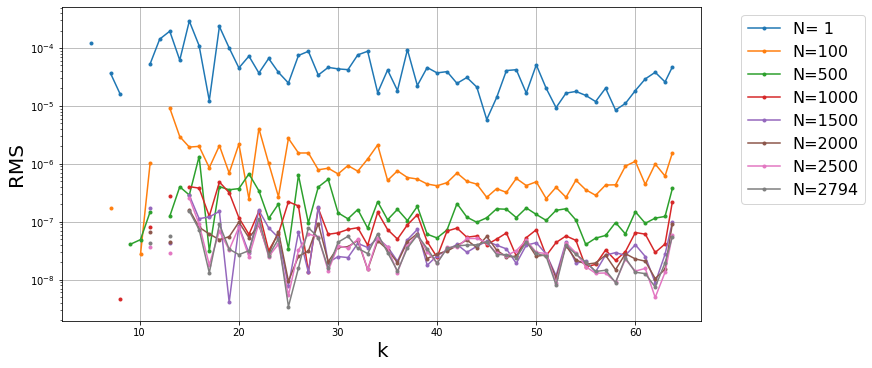

In [49]:
iw_set = [1,100,500,1000,1500,2000,2500,-1]
rms_of_tail = np.ndarray(shape=(wavenumbers_length, 1), dtype=float)

fig, ax = plt.subplots(figsize=(12,5), constrained_layout=True)
for iw in iw_set :
    for ik in list(range(k.shape[0])) :
        try : 
            index_of_tail = (np.nonzero((correlation_mean[::,ik,iw]*normalization[ik, iw])  < 1e-4))[0][0] 
            rms_of_tail[ik] = np.var( correlation_mean[index_of_tail::,ik,iw]*normalization[ik, iw] )
        except :
            index_of_zero = -1
            rms_of_tail[ik] = np.nan
    ax.plot(k,rms_of_tail, '.-', label='N=%2.f' % (curves[iw]))
ax.set(xlabel='k', ylabel='RMS'); ax.grid()
ax.set(yscale='log', xscale='linear')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()